In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")
from itertools import cycle
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import random
from sklearn import tree
import pydotplus
import scipy.stats as stats
import timeit
from sklearn.utils import column_or_1d 
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,\
 classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble

The dataset I used was 'NJ Transit + Amtrak (NEC) Rail Performance'. Here is the link: https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance

In [155]:
df_o = pd.read_csv('2019_04.csv')
df_o.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2019-04-01,4393,1.0,Long Branch,74,Long Branch,74,2019-04-02 00:08:00,2019-04-02 00:07:06,0.000000,departed,No Jersey Coast,NJ Transit
1,2019-04-01,4393,2.0,Long Branch,74,Elberon,40,2019-04-02 00:12:00,2019-04-02 00:13:09,1.150000,departed,No Jersey Coast,NJ Transit
2,2019-04-01,4393,3.0,Elberon,40,Allenhurst,4,2019-04-02 00:16:00,2019-04-02 00:18:07,2.116667,departed,No Jersey Coast,NJ Transit
3,2019-04-01,4393,4.0,Allenhurst,4,Asbury Park,8,2019-04-02 00:20:00,2019-04-02 00:21:12,1.200000,departed,No Jersey Coast,NJ Transit
4,2019-04-01,4393,5.0,Asbury Park,8,Bradley Beach,22,2019-04-02 00:23:00,2019-04-02 00:23:10,0.166667,departed,No Jersey Coast,NJ Transit


In [156]:
df_o.describe()

,stop_sequence,from_id,to_id,delay_minutes
count,213163.000000,238693.000000,238693.000000,213163.000000
mean,8.200063,4199.830297,4208.931670,3.697638
std,5.108761,11739.567890,11749.484752,4.768392
min,1.000000,1.000000,1.000000,0.000000
25%,4.000000,61.000000,61.000000,1.100000
50%,8.000000,105.000000,105.000000,2.350000
75%,12.000000,137.000000,137.000000,4.916667
max,26.000000,43599.000000,43599.000000,163.000000


There are more than 200 thousand observations in our dataset, so we need to picj up a sample.

In [157]:
df=df_o.sample(n=5000) #random pick up a simple

In [158]:
df.dtypes

date               object
train_id           object
stop_sequence     float64
from               object
from_id             int64
to                 object
to_id               int64
scheduled_time     object
actual_time        object
delay_minutes     float64
status             object
line               object
type               object
dtype: object

## Visualization

### Missing values

In [159]:
# Checking missing values
df.isnull().values.any()

True

In [160]:
df.isnull().sum()

date                0
train_id            0
stop_sequence     525
from                0
from_id             0
to                  0
to_id               0
scheduled_time    525
actual_time         0
delay_minutes     525
status              0
line                0
type                0
dtype: int64

We can see that the three variables:'stop_sequence','scheduled_time','delay_minutes' have missing values.

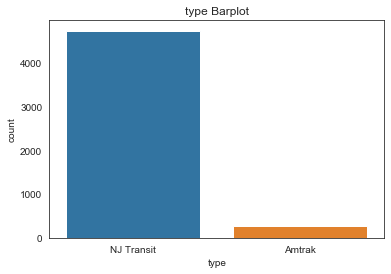

In [161]:
# before deleting missing values
plt.title("type Barplot")
sns.countplot(x="type", data=df)

In [162]:
# Removing missing values
df = df.dropna()

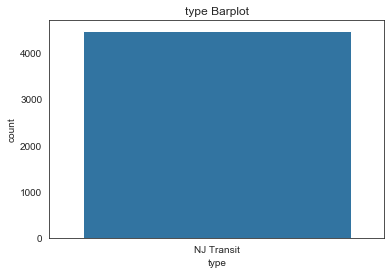

In [163]:
# after deleting missing values
plt.title("type Barplot")
sns.countplot(x="type", data=df)

From the two barplots, we can see that all missing values are from 'type:Amtrak'.So we decide just pay attention on the NJ Transit.

### Outlier

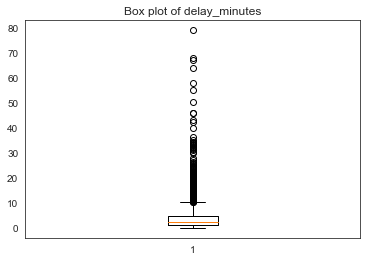

In [164]:
plt.boxplot(df["delay_minutes"])
plt.title("Box plot of delay_minutes")
plt.show()

### Explore some character variables

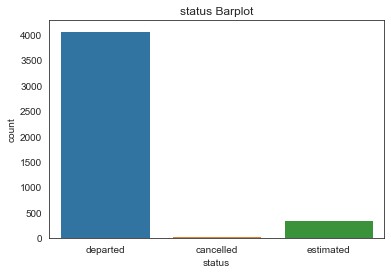

In [165]:
plt.title("status Barplot")
sns.countplot(x="status", data=df)

Most of trains departed.

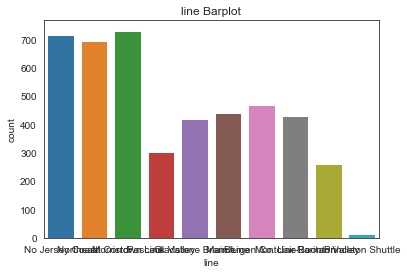

In [166]:
plt.title("line Barplot")
sns.countplot(x="line", data=df)

### Explore the distribution of numeric variables.

We want to explore the distribution of numeric variables.

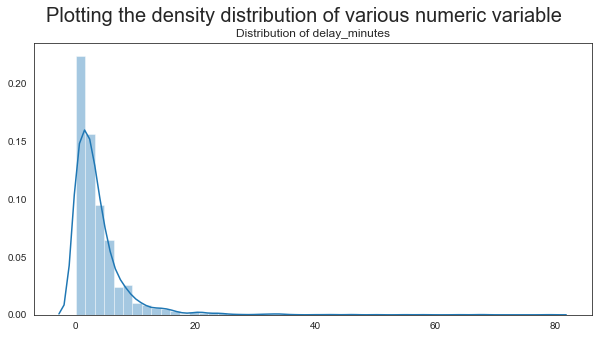

In [167]:
def draw_subplots(var_Name,tittle_Name,nrow=1,ncol=1,idx=1,fz=10): # Define a common module for drawing subplots.
    ax = plt.subplot(nrow,ncol,idx)                   #  idx - position of subplot in the main plotting window
    ax.set_title('Distribution of '+var_Name)         #  fz - the font size of Tittle in the main plotting window
    plt.suptitle(tittle_Name, fontsize=fz)

numeric_columns = ['delay_minutes']

fig,ax = plt.subplots(1,1, figsize=(10,5))
j=0  # reset the counter to plot 
title_Str="Plotting the density distribution of various numeric variable"

for i in numeric_columns:
    j +=1
    draw_subplots(i,title_Str,1,1,j,20) # create a 1x3 subplots for plotting distribution plots
    sns.distplot(df[i])
    plt.xlabel('')

Obviously, the numeric variable delay_minutesis not normal distribution.

### Choose variables

In [168]:
# Drop some uninteresting variables

df = df.drop(['date','train_id','stop_sequence','from','to','scheduled_time','actual_time','line'], 1)

In [169]:
# Convert some categorical variables to numerical

df['status'] = df['status'].map({'departed': 2, 'estimated': 1, 'cancelled': 0})
df['type'] = df['type'].map({'NJ Transit': 1, 'Amtrak': 0})
df.head()

,from_id,to_id,delay_minutes,status,type
103149,139,37169,11.050000,2,1
112266,105,38187,0.000000,0,1
2760,38,103,0.000000,2,1
184812,34,91,3.100000,2,1
41869,111,132,3.666667,2,1


In [170]:
columns = df[['from_id','to_id','delay_minutes','status','type']]

for column in columns: 
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [171]:
df.dtypes

from_id            int64
to_id              int64
delay_minutes    float64
status             int64
type               int64
dtype: object

## Normalization: Preprocessing

In [172]:
X = df.drop(['status'],1)
Y = df.drop(['from_id','to_id','delay_minutes','type'],1)

In [173]:
X_normalized = normalize(X)
X_normalized_df = pd.DataFrame(normalize(X), columns = X.columns)
X_normalized_df.dtypes

from_id          float64
to_id            float64
delay_minutes    float64
type             float64
dtype: object

In [174]:
X_normalized_df['from_id'] = np.float16(X_normalized_df['from_id'])
X_normalized_df['to_id'] = np.float16(X_normalized_df['to_id'])
X_normalized_df['delay_minutes'] = np.float16(X_normalized_df['delay_minutes'])
X_normalized_df['type'] = np.float16(X_normalized_df['type'])
X_normalized_df.dtypes

from_id          float16
to_id            float16
delay_minutes    float16
type             float16
dtype: object

In [175]:
#Use silhouette score
range_n_clusters = list (range(2,7))
print ("Number of clusters from 2 to 6: \n", range_n_clusters)
for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_normalized_df)
    centers = clusterer.cluster_centers_
    score = silhouette_score (X_normalized_df, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

Number of clusters from 2 to 6: 
 [2, 3, 4, 5, 6]
For n_clusters = 2, silhouette score is 0.5478338474279639
For n_clusters = 3, silhouette score is 0.6056404916317348
For n_clusters = 4, silhouette score is 0.5977403026408106
For n_clusters = 5, silhouette score is 0.6213420694360765
For n_clusters = 6, silhouette score is 0.6118513845182582


From here, we can see that 5 clusters may be the best choose.

## K-Means

In [176]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10)
Y_pred = km.fit_predict(X_normalized_df)
Y_pred

array([3, 3, 0, ..., 1, 1, 2])

In [177]:
df["Cluster"]=Y_pred
df.head()

,from_id,to_id,delay_minutes,status,type,Cluster
103149,139,37169,11.050000,2,1,3
112266,105,38187,0.000000,0,1,3
2760,38,103,0.000000,2,1,0
184812,34,91,3.100000,2,1,0
41869,111,132,3.666667,2,1,4


In [178]:
df = df.sort_values(['Cluster'])
df

,from_id,to_id,delay_minutes,status,type,Cluster
125756,58,116,0.000000,2,1,0
59245,61,97,5.083333,2,1,0
130384,17,48,0.000000,2,1,0
30682,41,70,3.350000,2,1,0
124178,18,45,7.700000,2,1,0
...,...,...,...,...,...,...
160074,139,119,1.150000,2,1,4
170570,105,105,0.000000,2,1,4
130670,38417,38174,2.000000,1,1,4
21471,145,136,3.083333,2,1,4


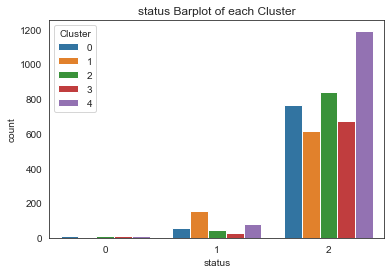

In [179]:
plt.title("status Barplot of each Cluster")
sns.countplot(x="status",hue="Cluster", data=df)

### Mean-shift

In [180]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_normalized, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
Y_pred1 = ms.fit_predict(X_normalized_df)
ms.fit(X_normalized)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 6


In [181]:
df["Cluster1"]=Y_pred1
df.head()

,from_id,to_id,delay_minutes,status,type,Cluster,Cluster1
125756,58,116,0.000000,2,1,0,4
59245,61,97,5.083333,2,1,0,4
130384,17,48,0.000000,2,1,0,2
30682,41,70,3.350000,2,1,0,2
124178,18,45,7.700000,2,1,0,0


In [184]:
df = df.sort_values(['Cluster1'])
print(df)

        from_id  to_id  delay_minutes  status  type  Cluster  Cluster1
120563       59  37169       2.283333       2     1        3         0
16071        26     86       6.166667       2     1        0         0
168153      139    119       2.183333       2     1        4         0
99035       105    106       7.166667       2     1        4         0
210896      124    124       0.000000       2     1        4         0
...         ...    ...            ...     ...   ...      ...       ...
199164      131     52       3.183333       2     1        2         5
201596      129    129       4.183333       2     1        4         5
67950        74     73       2.200000       2     1        4         5
15249       140    106       7.166667       2     1        4         5
117768      103     38       7.066667       2     1        2         5

[4475 rows x 7 columns]


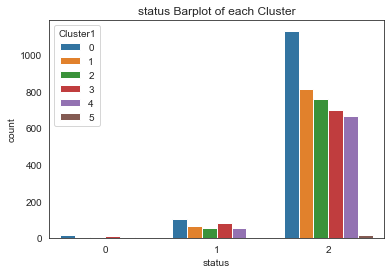

In [186]:
plt.title("status Barplot of each Cluster")
sns.countplot(x="status",hue="Cluster1", data=df)

## Supervised 

In [187]:
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized_df, Y, test_size=0.4, random_state=0)

### Model 1: Decision Tree Model

In [188]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 0)
dtmodel=decision_tree.fit(X_train,Y_train)
decision_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

#### Cross validation

In [189]:
scores = cross_val_score(decision_tree, X_train, Y_train, cv=10)
print(scores.mean())

0.9303675429155824


#### Classification_report and Confusion matrix

In [190]:
Y_pred = dtmodel.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Decision Tree Model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Decision Tree Model Classification report:
Accuracy:  0.9335195530726257
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.26      0.92      0.40        37
           2       1.00      0.93      0.96      1753

    accuracy                           0.93      1790
   macro avg       0.42      0.62      0.46      1790
weighted avg       0.98      0.93      0.95      1790

Confusion matrix:
[[   0    0   19]
 [   0   34   97]
 [   0    3 1637]]


### Model 2: Random forest model

In [191]:
rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc

,feature,importance
0,to_id,0.309327
1,delay_minutes,0.269960
2,from_id,0.230167
3,type,0.190546


#### Cross validation

In [192]:
scores = cross_val_score(rfc, X_train, Y_train, cv=10)
print(scores.mean())

0.957542809369514


#### Classification_report and Confusion matrix

In [193]:
Y_pred = dtmodel_R.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Random forest model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Random forest model Classification report:
Accuracy:  0.9932960893854749
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.97      0.99      0.98       128
           2       1.00      0.99      1.00      1646

    accuracy                           0.99      1790
   macro avg       0.90      0.95      0.93      1790
weighted avg       0.99      0.99      0.99      1790

Confusion matrix:
[[  14    0    5]
 [   0  127    4]
 [   2    1 1637]]


## Conclusion

For unsupervised learning, we got the silhouette score for each number of cluster from 2 to 6 and the score reaches the maximum value at n = 5. So we decide to use n = 5 to do the K-Means cluster. We show the barplot of status and type for each cluster. From these barplots, we can see that the Cluster4 contains the most observations and the Cluster2 contains the least observations. For the other clusters, we don't see any obvious features of them. From the result of mean shift,it shows us the resule the number of cluster is 6.

For supervised learning, we decided to use 'status' to classfy our dataset. We used two models: Decision Tree Model and Random forest model. And we also do show the cross validation, Classification_report and Confusion matrix for each model. From the result, we can conclude that the result of the classification is perfect. We got  good cross validation score, accuracy and confusion matrix.